<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader

In [31]:
%%time

batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

CPU times: user 242 µs, sys: 20 µs, total: 262 µs
Wall time: 270 µs


In [29]:
%%time

batch_size = 1024

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

CPU times: user 266 µs, sys: 22 µs, total: 288 µs
Wall time: 297 µs


In [30]:
%%time

batch_size = 4096

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

CPU times: user 381 µs, sys: 39 µs, total: 420 µs
Wall time: 429 µs


Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

### **Ответ: чем больше тем дольше**

Посмотрим на какую-нибудь картинку:

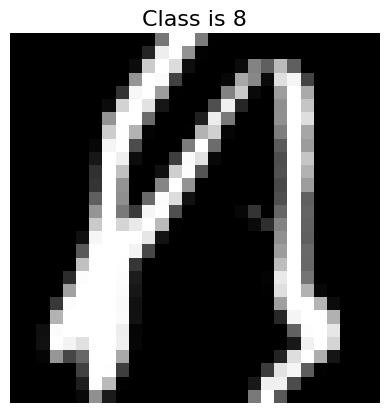

In [10]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿

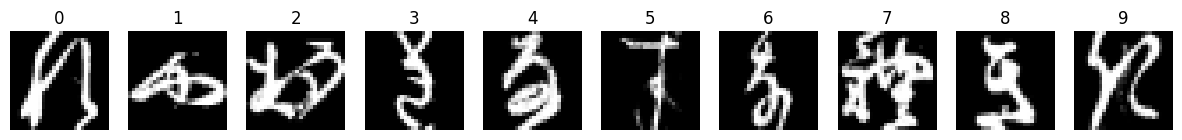

In [11]:
fig, axs = plt.subplots(1, 10, figsize=(15, 5))

for i in range(0, 10):
    axs[i].imshow(trainset[i][0].reshape(28,28,1), cmap="gray")
    axs[i].axis('off')
    axs[i].set_title(i)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [13]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
        self.activation1 = nn.ReLU() 
        self.activation2 = nn.ReLU() 
        self.activation3 = nn.LogSoftmax(dim=1) 
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) 
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

In [16]:
for param in FCNet().parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [20]:
f'{256 * 784 + 128 * 256 + 10 * 128 } весов и {256 + 128 + 10} bias-ов'

'234752 весов и 394 bias-ов'

In [19]:
234752 + 394

235146

### **Ответ: 235146**

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [32]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [33]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [34]:
n_epochs = 10
loss_history = []


for epoch in range(n_epochs):
    epoch_loss = 0
    
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9284
Epoch=2 loss=0.4525
Epoch=3 loss=0.3591
Epoch=4 loss=0.3007
Epoch=5 loss=0.2575
Epoch=6 loss=0.2241
Epoch=7 loss=0.1956
Epoch=8 loss=0.1711
Epoch=9 loss=0.1512
Epoch=10 loss=0.1332


In [35]:
get_accuracy(fc_net, testloader)

0.8771

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [36]:
std, mean = torch.std_mean(trainset.data.to(torch.float32))
max_val = torch.max(trainset.data.to(torch.float32))
std, mean = std / max_val, mean / max_val
print(mean, std)

tensor(0.1918) tensor(0.3483)


In [37]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [38]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [39]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6999
Epoch=2 loss=0.3116
Epoch=3 loss=0.2298
Epoch=4 loss=0.1781
Epoch=5 loss=0.1434
Epoch=6 loss=0.1163
Epoch=7 loss=0.0955
Epoch=8 loss=0.0784
Epoch=9 loss=0.0656
Epoch=10 loss=0.0531


In [40]:
get_accuracy(fc_net, testloader)

0.8939

Как изменилась `accuracy` после нормализации?

ЛУЧШЕ!

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [41]:
loss_function = nn.CrossEntropyLoss()
lr = 0.001

In [42]:
n_epochs = 10


for activation_fun in [nn.GELU, nn.Sigmoid, nn.Tanh]:
    
    print(f'Activation: {activation_fun.__name__}')
    
    n_net = FCNet()
    optimizer = torch.optim.Adam(n_net.parameters(), lr=3e-4)
    n_net.activation1 = activation_fun()
    n_net.activation2 = activation_fun()
    
    loss_history = []

    for epoch in range(n_epochs):
        epoch_loss = 0

        for images, labels in trainloader: 
            optimizer.zero_grad() 
            outputs = n_net(images)
            loss = loss_function(outputs, labels)
            loss.backward() 
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    print(f'Accuracy: {get_accuracy(n_net, testloader)}')
    print()


Activation: GELU
Epoch=1 loss=0.6547
Epoch=2 loss=0.2796
Epoch=3 loss=0.1991
Epoch=4 loss=0.1518
Epoch=5 loss=0.1192
Epoch=6 loss=0.0945
Epoch=7 loss=0.0762
Epoch=8 loss=0.0612
Epoch=9 loss=0.0485
Epoch=10 loss=0.0378
Accuracy: 0.9009

Activation: Sigmoid
Epoch=1 loss=1.5349
Epoch=2 loss=0.7393
Epoch=3 loss=0.5432
Epoch=4 loss=0.4433
Epoch=5 loss=0.3737
Epoch=6 loss=0.3208
Epoch=7 loss=0.2767
Epoch=8 loss=0.2412
Epoch=9 loss=0.2119
Epoch=10 loss=0.1869
Accuracy: 0.8568

Activation: Tanh
Epoch=1 loss=0.7779
Epoch=2 loss=0.3845
Epoch=3 loss=0.2584
Epoch=4 loss=0.1842
Epoch=5 loss=0.1372
Epoch=6 loss=0.1031
Epoch=7 loss=0.0768
Epoch=8 loss=0.0573
Epoch=9 loss=0.0422
Epoch=10 loss=0.0308
Accuracy: 0.9007



In [43]:
fc_net.activation1 = nn.GELU()
fc_net.activation2 = nn.GELU()

С использованием какой функции активации удалось досчить наибольшей `accuracy`?
## GELU !

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [44]:
loss_function = nn.CrossEntropyLoss()
lr = 0.001

In [55]:
n_epochs = 10

for optim in [torch.optim.Adam, torch.optim.Adagrad, torch.optim.RMSprop]:
    
    print(f'Optimizer: {optim.__name__}')
    
    loss_history = []
    n_net = FCNet()
    n_net.activation1 = nn.GELU()
    n_net.activation2 = nn.GELU()
    optimizer = optim(n_net.parameters(), lr=3e-4)
    
    for epoch in range(n_epochs):
        epoch_loss = 0

        for images, labels in trainloader: 
            optimizer.zero_grad() 
            outputs = n_net(images)
            loss = loss_function(outputs, labels)
            loss.backward() 
            optimizer.step()

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    print(f'Accuracy: {get_accuracy(n_net, testloader)}')
    print()


Optimizer: Adam
Epoch=1 loss=0.6623
Epoch=2 loss=0.2853
Epoch=3 loss=0.2045
Epoch=4 loss=0.1551
Epoch=5 loss=0.1228
Epoch=6 loss=0.0966
Epoch=7 loss=0.0779
Epoch=8 loss=0.0618
Epoch=9 loss=0.0490
Epoch=10 loss=0.0383
Accuracy: 0.9038

Optimizer: Adagrad
Epoch=1 loss=1.3474
Epoch=2 loss=0.8086
Epoch=3 loss=0.6824
Epoch=4 loss=0.6209
Epoch=5 loss=0.5822
Epoch=6 loss=0.5544
Epoch=7 loss=0.5322
Epoch=8 loss=0.5146
Epoch=9 loss=0.4997
Epoch=10 loss=0.4865
Accuracy: 0.7226

Optimizer: RMSprop
Epoch=1 loss=0.4394
Epoch=2 loss=0.2359
Epoch=3 loss=0.1721
Epoch=4 loss=0.1327
Epoch=5 loss=0.1042
Epoch=6 loss=0.0820
Epoch=7 loss=0.0651
Epoch=8 loss=0.0510
Epoch=9 loss=0.0396
Epoch=10 loss=0.0307
Accuracy: 0.9027



### Let's continue with Adam

In [56]:
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

у меня Macbook, поэтому попробую перевести на GPU

In [60]:
DEVICE = "mps" 
torch.backends.mps.is_available()

True

In [61]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        
        is_less_zero = x < 0
        x[is_less_zero] = 0

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [62]:
def get_accuracy_mps(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

In [63]:
fc_net = FCNet().to(DEVICE)
fc_net.activation1 = CustomReLU()
fc_net.activation2 = CustomReLU()

loss_function = nn.CrossEntropyLoss()

lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [64]:
n_epochs = 10
loss_history = []


for epoch in range(n_epochs):
    epoch_loss = 0
    
    for images, labels in trainloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad() 
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
print(f'Accuracy = {get_accuracy_mps(fc_net, testloader)}')

Epoch=1 loss=0.6909
Epoch=2 loss=0.3032
Epoch=3 loss=0.2237
Epoch=4 loss=0.1733
Epoch=5 loss=0.1391
Epoch=6 loss=0.1134
Epoch=7 loss=0.0927
Epoch=8 loss=0.0761
Epoch=9 loss=0.0627
Epoch=10 loss=0.0521
Accuracy = 0.9011


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах (??????), то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

### Двухметровый биоинформатик валидирует модель где-то в джунглях Амазонии

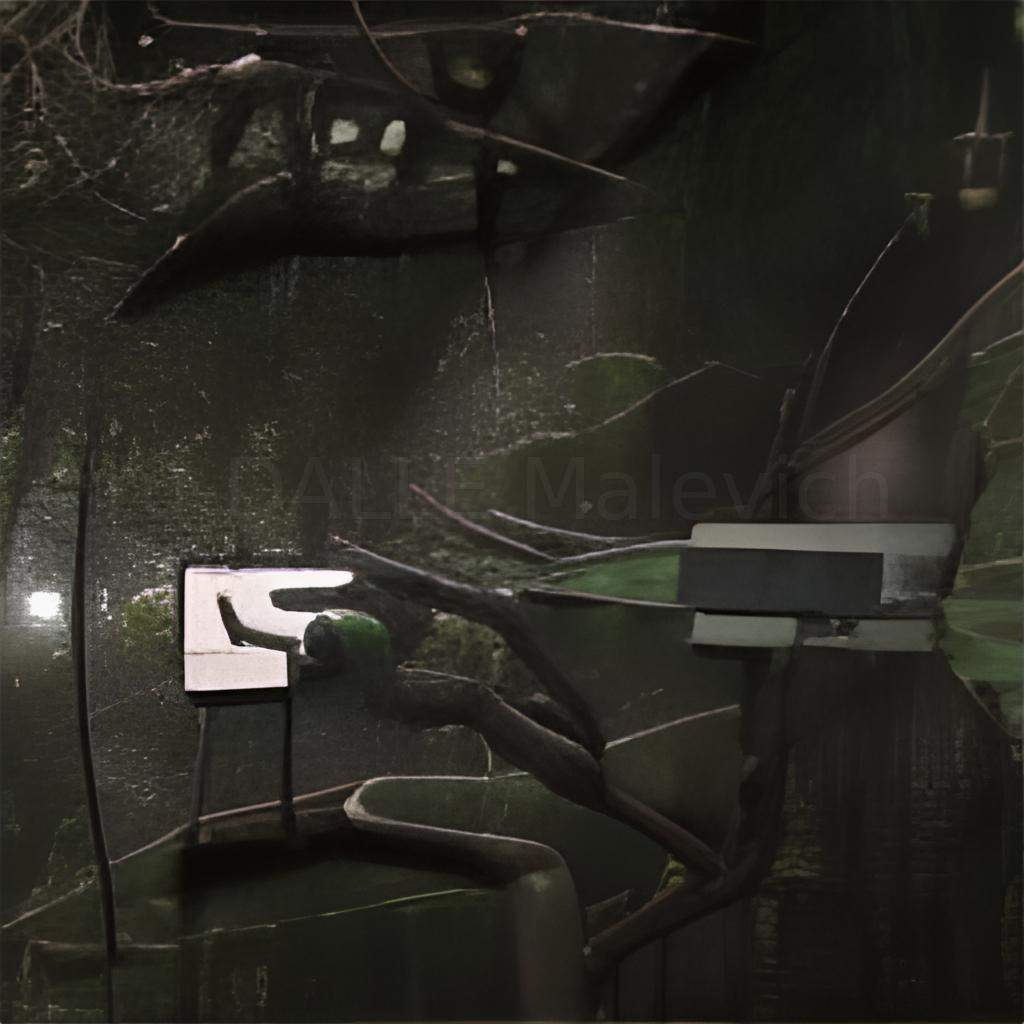

### Одетый в бадлон кот-бегемот сидит на поребрике,на пяти углах, кушая шаверму

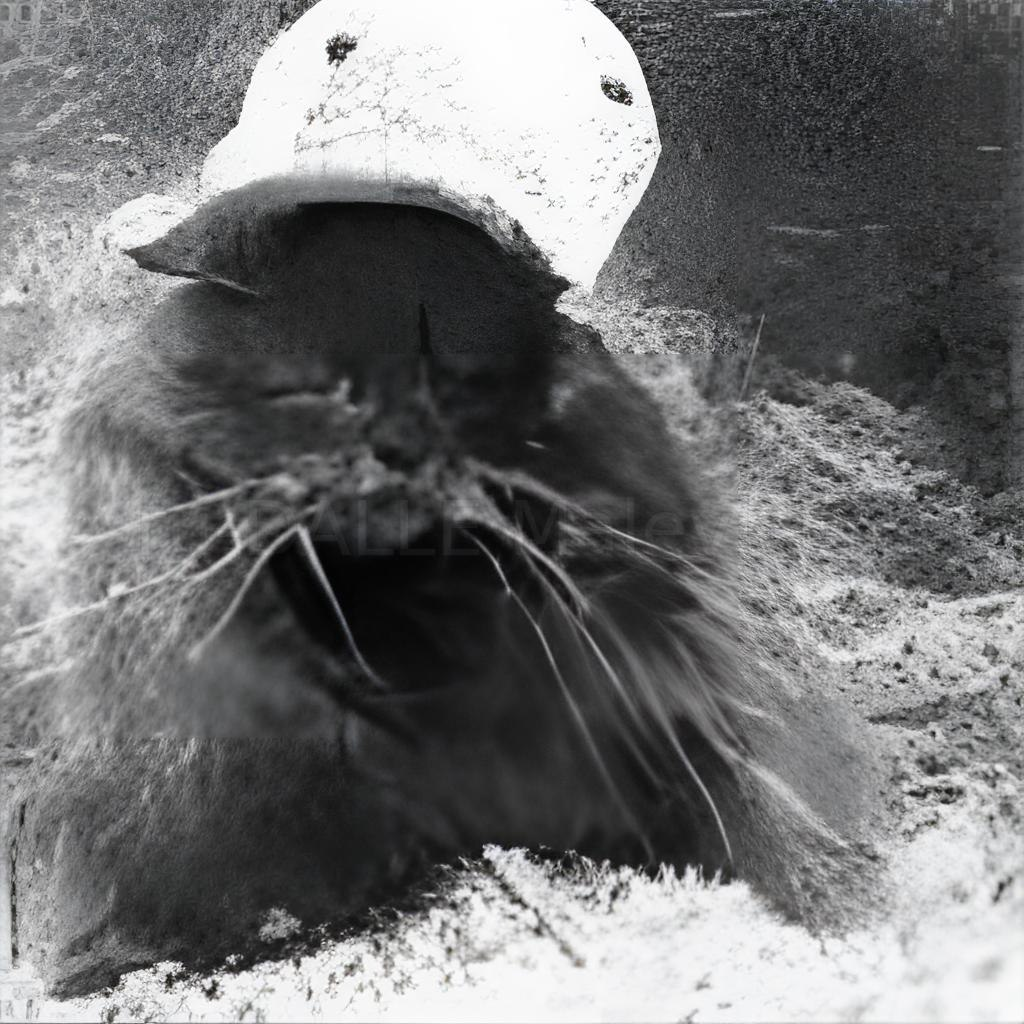

### Человек-паук из Вьетнама

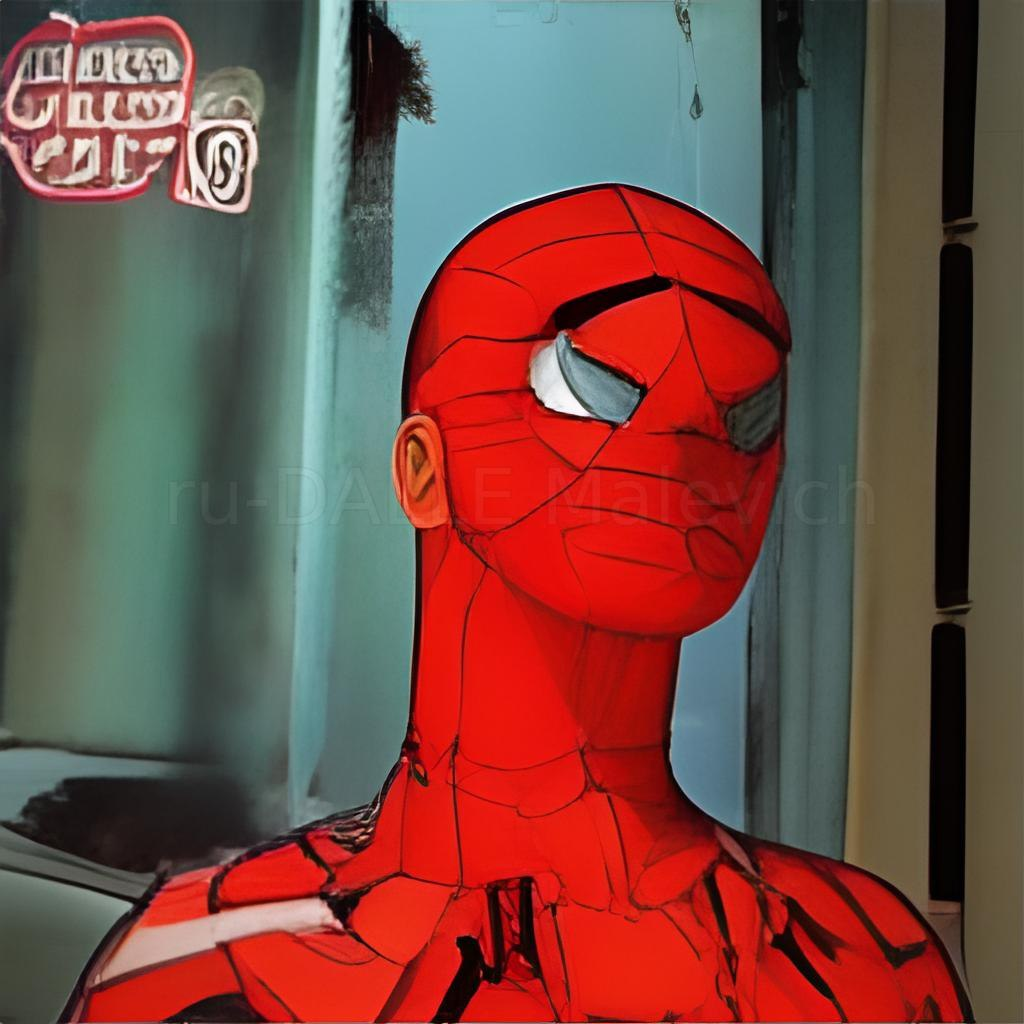